In [1]:
import pandas as pd
from io import StringIO
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_trace(trace_dir, trace_file, worker_id=None):
    trace_filepath = os.path.join(trace_dir, trace_file)
    
    with open(trace_filepath,"r") as rf:
        new_trace = StringIO()
        line = rf.readline()
        while line:
            line_list = line.split()
            if line_list[0] == "[trace]" or line_list[0] == "[PROF]":
                new_trace.write(line)
            line = rf.readline()
       
    new_trace.seek(0)
    df = pd.read_csv(new_trace, sep=" ", names=["InfoType", "EventType", "EventState", "ID", "Time"])
    del df["InfoType"]
    
    if worker_id is not None:
        df.insert(0, "WorkerID", worker_id)
        
    new_trace.close()
    
    return df

## Compare masking/unmasking (hpc3 -> hpc0)

In [3]:
dir_id = "hpc3-hpc0_unmask_nossl"
params_size = ["10000", "5000000", "10000000"]
message_size_list = []
avg_durations = []
avg_nc_send_time = []
avg_nc_recv_time = []

In [4]:
for p_size in params_size:
    
    trace_dir = "/home/posheng/billy_ws/fl_025/paslab/trace/model_send_params/" + dir_id + "/node_num_" + p_size
    coord_trace_file = "coord.txt"
    coord_df = read_trace(trace_dir, coord_trace_file)
    
    coord_df = coord_df[4:].reset_index()
    del coord_df["index"]
    message_size = int(coord_df.iloc[1]['EventState'])
    message_size_list.append(message_size)
    
    start_indices = list(coord_df[coord_df["EventType"] == "MessageSize"].index)
    durations = np.zeros(len(start_indices))
    nc_send_durations = np.zeros(len(start_indices))
    nc_recv_durations = np.zeros(len(start_indices))
    
    for i in range(len(start_indices)):
        idx = start_indices[i]
        durations[i] = coord_df.iloc[idx+4]["Time"]
        nc_send_durations[i] = coord_df.iloc[idx+2]["Time"] - coord_df.iloc[idx+1]["Time"]
        nc_recv_durations[i] = coord_df.iloc[idx+3]["Time"] - coord_df.iloc[idx+2]["Time"]

    
    avg_durations.append(durations.mean())
    avg_nc_send_time.append(nc_send_durations.mean())
    avg_nc_recv_time.append(nc_recv_durations.mean())

In [5]:
avg_durations

[0.006088125705718994, 1.1653847575187684, 3.0666594386100767]

In [6]:
avg_nc_send_time

[0.0001287221908569336, 0.6173547506332397, 1.8805806636810303]

In [7]:
avg_nc_recv_time

[0.004267764091491699, 0.25637178421020507, 0.5533512949943542]

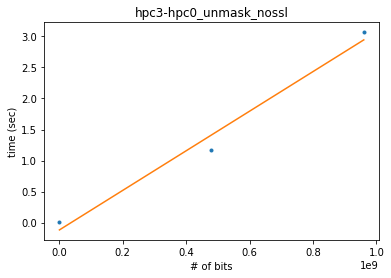

In [8]:
index_list = [int(message_size)*8 for message_size in message_size_list]
z2 = np.polyfit(index_list, avg_durations, 1)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.title(dir_id)
plt.xlabel('# of bits')
plt.ylabel('time (sec)')
plt.plot(index_list, avg_durations, '.', xp, p2(xp))

In [11]:
unmask_no_ssl_avg_durations = avg_durations

In [12]:
1/z2[0] / 1000 / 1000

313.3488929754325

In [13]:
dir_id = "hpc3-hpc0_mask_ssl"
worker_id = "hpc0"
params_size = ["10000", "5000000", "10000000"]
message_size_list = []
avg_durations = []
avg_nc_send_time = []
avg_nc_recv_time = []

for p_size in params_size:
    trace_dir = "/home/posheng/billy_ws/fl_025/paslab/trace/model_send_params/" + dir_id + "/node_num_" + p_size
    coord_trace_file = "coord.txt"
    worker_trace_file = worker_id + ".txt"

    coord_df = read_trace(trace_dir, coord_trace_file)
    
    ## preproc
    idx_list = []

    for i in range(len(coord_df)):
        row =  coord_df.iloc[i]
        if row["EventType"][:7] == "WEBSOCK":
            idx_list.append(i)
    
    coord_df = coord_df.drop(idx_list)    
    coord_df = coord_df[1:].reset_index()
    
    avg_durations.append(coord_df["Time"][1:].mean())

In [15]:
mask_ssl_avg_durations = avg_durations

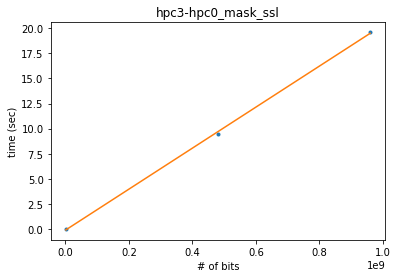

In [18]:
message_size_list = [123417, 60007894, 120011202]
index_list = [int(message_size)*8 for message_size in message_size_list]
z2 = np.polyfit(index_list, avg_durations, 1)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.title(dir_id)
plt.xlabel('# of bits')
plt.ylabel('time (sec)')
plt.plot(index_list, avg_durations, '.', xp, p2(xp))

In [19]:
1/z2[0] / 1000 / 1000

49.00481178735647

In [20]:
dir_id = "hpc3-hpc0_unmask_ssl"
worker_id = "hpc0"
params_size = ["10000", "5000000", "10000000"]
message_size_list = []
avg_durations = []
avg_nc_send_time = []
avg_nc_recv_time = []

for p_size in params_size:
    trace_dir = "/home/posheng/billy_ws/fl_025/paslab/trace/model_send_params/" + dir_id + "/node_num_" + p_size
    coord_trace_file = "coord.txt"
    worker_trace_file = worker_id + ".txt"

    coord_df = read_trace(trace_dir, coord_trace_file)
    
    ## preproc
    idx_list = []

    for i in range(len(coord_df)):
        row =  coord_df.iloc[i]
        if row["EventType"][:7] == "WEBSOCK":
            idx_list.append(i)
    
    coord_df = coord_df.drop(idx_list)    
    coord_df = coord_df[1:].reset_index()
    
    avg_durations.append(coord_df["Time"][1:].mean())

In [21]:
unmask_ssl_avg_durations = avg_durations

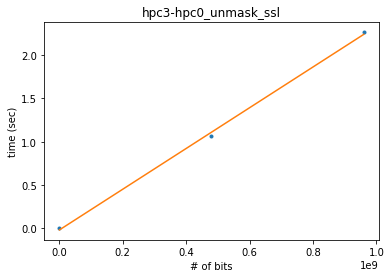

In [22]:
message_size_list = [123417, 60007894, 120011202]
index_list = [int(message_size)*8 for message_size in message_size_list]
z2 = np.polyfit(index_list, avg_durations, 1)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.title(dir_id)
plt.xlabel('# of bits')
plt.ylabel('time (sec)')
plt.plot(index_list, avg_durations, '.', xp, p2(xp))

In [23]:
1/z2[0] / 1000 / 1000

424.82154272100183

In [24]:
dir_id = "hpc3-hpc0"
worker_id = "hpc0"
params_size = ["10000", "5000000", "10000000"]
message_size_list = []
avg_durations = []
avg_nc_send_time = []
avg_nc_recv_time = []

for p_size in params_size:
    trace_dir = "/home/posheng/billy_ws/fl_025/paslab/trace/model_send_params/" + dir_id + "/node_num_" + p_size
    coord_trace_file = "coord.txt"
    worker_trace_file = worker_id + ".txt"

    coord_df = read_trace(trace_dir, coord_trace_file)
    
    ## preproc
    idx_list = []

    for i in range(len(coord_df)):
        row =  coord_df.iloc[i]
        if row["EventType"][:7] == "WEBSOCK":
            idx_list.append(i)
    coord_df = coord_df.drop(idx_list)
    
    
    coord_df = coord_df[4:].reset_index()
    del coord_df["index"]
    message_size = int(coord_df.iloc[0]['EventState'])
    message_size_list.append(message_size)
    
    w_df = read_trace(trace_dir, worker_trace_file, worker_id)

    start_indices = list(coord_df[coord_df["EventType"] == "MessageSize"].index)
    
    durations = np.zeros(len(start_indices))
    nc_send_durations = np.zeros(len(start_indices))
    nc_recv_durations = np.zeros(len(start_indices))
    for i in range(len(start_indices)):
        idx = start_indices[i]
        durations[i] = coord_df.iloc[idx+4]["Time"]
        nc_send_durations[i] = coord_df.iloc[idx+2]["Time"] - coord_df.iloc[idx+1]["Time"]
        nc_recv_durations[i] = coord_df.iloc[idx+3]["Time"] - coord_df.iloc[idx+2]["Time"]
    
    avg_durations.append(durations.mean())
    avg_nc_send_time.append(nc_send_durations.mean())
    avg_nc_recv_time.append(nc_recv_durations.mean())

In [25]:
message_size_list = [123417, 60007894, 120011202]

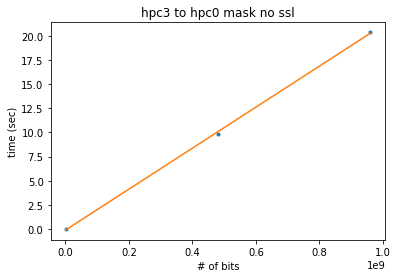

In [29]:
index_list = [int(message_size)*8 for message_size in message_size_list]
z2 = np.polyfit(index_list, avg_durations, 1)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.title('hpc3 to hpc0 mask no ssl')
plt.xlabel('# of bits')
plt.ylabel('time (sec)')
plt.plot(index_list, avg_durations, '.', xp, p2(xp))

In [30]:
mask_no_ssl_avg_durations = avg_durations

In [31]:
1/z2[0] / 1024 / 1024

44.984149737077594

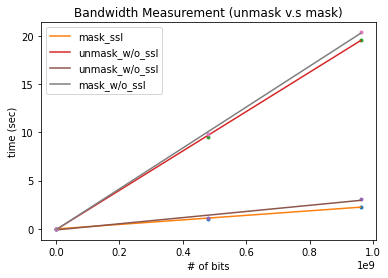

In [34]:
index_list = [int(message_size)*8 for message_size in message_size_list]

plt.title('Bandwidth Measurement (unmask v.s mask)')
plt.xlabel('# of bits')
plt.ylabel('time (sec)')

p_list = []
z_list = []

# for label, values in results.items():

## unmask_ssl
z2 = np.polyfit(index_list, unmask_ssl_avg_durations, 1)
z_list.append(z2)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.plot(index_list, unmask_ssl_avg_durations, '.')
p, = plt.plot(xp, p2(xp))
p_list.append(p)

## mask_ssl
z2 = np.polyfit(index_list, mask_ssl_avg_durations, 1)
z_list.append(z2)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.plot(index_list, mask_ssl_avg_durations, '.')
p, = plt.plot(xp, p2(xp))
p_list.append(p)

## unmask_no_ssl
z2 = np.polyfit(index_list, unmask_no_ssl_avg_durations, 1)
z_list.append(z2)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.plot(index_list, unmask_no_ssl_avg_durations, '.')
p, = plt.plot(xp, p2(xp))
p_list.append(p)

## mask_no_ssl
z2 = np.polyfit(index_list, mask_no_ssl_avg_durations, 1)
z_list.append(z2)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.plot(index_list, mask_no_ssl_avg_durations, '.')
p, = plt.plot(xp, p2(xp))
p_list.append(p)
    
plt.legend(p_list, ["mask_ssl", "unmask_w/o_ssl", "unmask_w/o_ssl", "mask_w/o_ssl"], loc='upper left')